In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [3]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm2a.1_0h 04 arm2a.1_2h 05 arm2a.2_0h 06 arm2a.2_2h
1 1.0693000 32.48505     1.0210121      34.41672            NA            NA
2 1.0257411 32.71100     0.9075192      35.87825            NA            NA
3 0.9117225 29.89234     1.0792282      32.33529            NA            NA
4        NA       NA            NA            NA            NA            NA
5 1.0376597 18.57463     1.1172871      24.45281            NA            NA
6 0.9953897 20.46748     1.0000000      23.78414            NA            NA
  07 flg22_0h 08 flg22_2h   Group
1   1.0693000    75.15015 Trial01
2   1.0257411    73.09517 Trial01
3   0.9117225    70.60528 Trial01
4          NA          NA    <NA>
5   0.9930925    90.63071 Trial02
6   1.0069556    90.00468 Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01   1.07
2 02 wt_2h      Trial01  32.5 
3 03 arm2a.1_0h Trial01   1.02
4 04 arm2a.1_2h Trial01  34.4 
5 05 arm2a.2_0h Tri

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  1.07 
2 01 wt_0h  Trial01  1.03 
3 01 wt_0h  Trial01  0.912
4 02 wt_2h  Trial01 32.5  
5 02 wt_2h  Trial01 32.7  
6 02 wt_2h  Trial01 29.9  


[1] 36 52

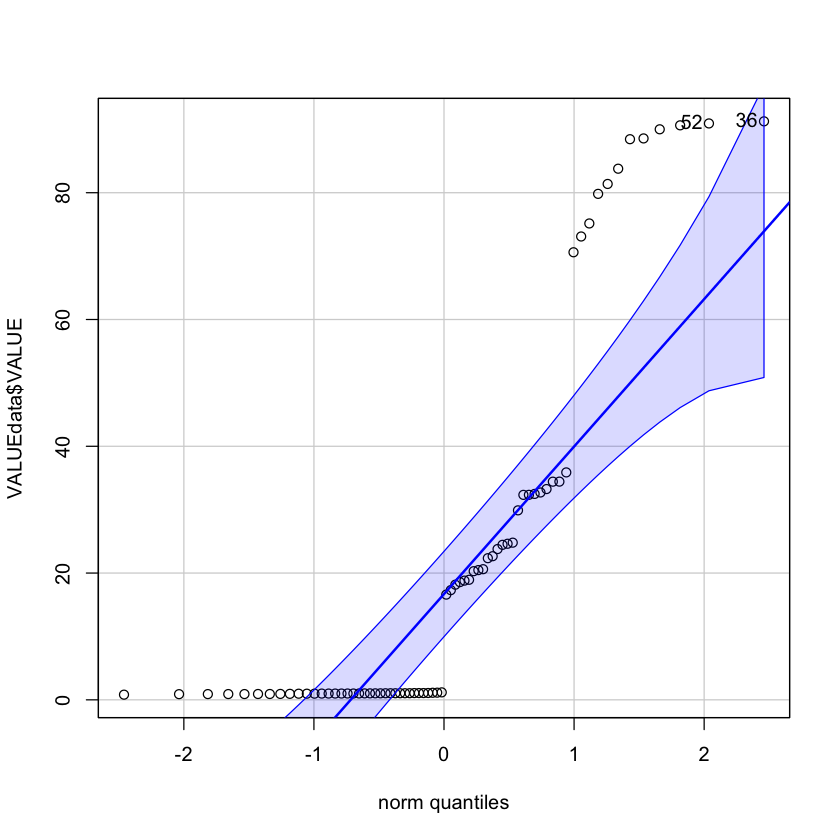

In [4]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   441.8    464.6   -210.9    421.8       62 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.88715 -0.06939  0.00067  0.03513  2.04891 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  0.05087 0.2255  
 Residual             20.44700 4.5218  
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                        Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             1.001753   1.310203 56.994067   0.765    0.448    
Treatment02 wt_2h      22.423518   1.846032 67.983906  12.147   <2e-16 ***
Treatment03 arm2a.1_0h -0.002130   2.263647 71.998730  -0.001    0.999    
Treatment04 arm2a.1_2h 27.863348   2.263647 71.998730  12.309   <2e-16 ***
Treatment05 arm2a.2_0h  0.003686   2.263647 71.998730   0.002    0.9

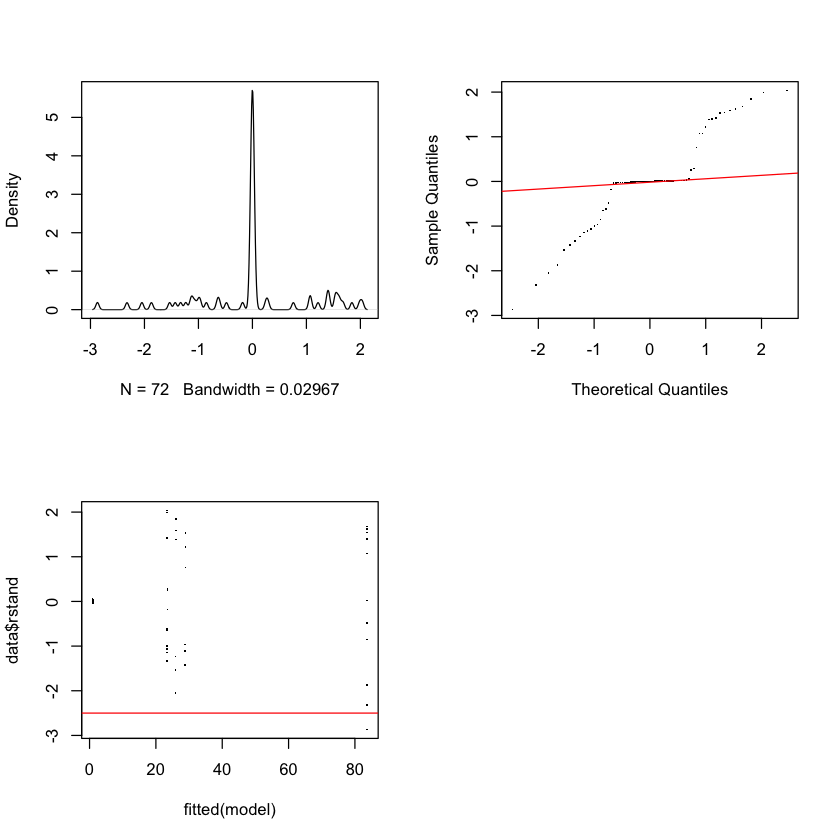

In [5]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [6]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :61807   Min.   :8830   Min.   :7   Min.   :68.81   Min.   :431.8  
 1st Qu.:61807   1st Qu.:8830   1st Qu.:7   1st Qu.:68.81   1st Qu.:431.8  
 Median :61807   Median :8830   Median :7   Median :68.81   Median :431.8  
 Mean   :61807   Mean   :8830   Mean   :7   Mean   :68.81   Mean   :431.8  
 3rd Qu.:61807   3rd Qu.:8830   3rd Qu.:7   3rd Qu.:68.81   3rd Qu.:431.8  
 Max.   :61807   Max.   :8830   Max.   :7   Max.   :68.81   Max.   :431.8  
     Pr(>F)         
 Min.   :3.128e-54  
 1st Qu.:3.128e-54  
 Median :3.128e-54  
 Mean   :3.128e-54  
 3rd Qu.:3.128e-54  
 Max.   :3.128e-54  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                     Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0       